In [1]:
import numpy as np
import pylab
import random

# k-means Clustering

This notebook is an implementation of the k-means clustering algorithm.

### Preparation

This cell contains the definition of a data point, combining an identifying name with a feature vector. Obviously, if we cannot identify the data points in the end result, the algorithm will be of no use for classification, so this class needs to be used as an input to the clusters.

I've added some magic methods to make the class hopefully interoperable with normal lists, which will be cool when calculating the metrics.

In [2]:
class DataPoint:
    def __init__( self, name, features, label = None ):
        """
        Creates a data point with a (uniquely) identifying name, and optionally a user-readable label
        """
        # name is read-only
        self._name = name
        # the feature vector is readonly
        self._features = features
        # the label is for user convenience, it can be changed at any time.
        self.label = label
    
    @property
    def name(self):
        return self._name
    
    @property
    def features(self):
        return self._features[:]
    
    def __eq__(self, other):
        return np.all(self._features == other.features)
    
    # I swear, it turns itself into a list-like data structure
    # Funniest shit I've ever seen
    def __len__(self):
        return len(self._features)
    def __getitem__(self,key):
        return self._features[key]
    def __iter__(self):
        return iter(self._features)
    
    # User output convenience
    def __repr__(self):
        return f"{self.name}" + (f" ({self.label})" if self.label != None else "") \
            + f": {str(self.features)}"
    def __str__(self):
        return f"Point {self.label if self.label != None else self.name} {str(self._features)}"

These metrics can be used to calculate the distance between points in our feature space. Their input can be a `DataPoint` or just a list, and the result is a scalar.

To motivate the Minkowski metric, consider the standard distance metric in $\mathbb{R}^n$, the _Euclidean Metric_:
$$dist(a,b)=|b-a|=\sqrt[\leftroot{4}\uproot{4}2]{\sum^n_{k=1} (b_k-a_k)^2}$$
Note the exponents of $2$ in the square root and for each term of the sum. The _Minkowski Metric_ generalizes the formula, replacing these exponents with any positive integer $p$:
$$dist_p(a,b)=\sqrt[\leftroot{4}\uproot{4}p]{\sum^n_{k=1} |b_k-a_k|^p}$$

In [3]:
def minkowskiDist(v1,v2,p):
    return sum(abs((a-b)**p) for a,b in zip(v1,v2))**(1/p)

def euclideanDist(v1,v2):
    return minkowskiDist(v1,v2,2)

Next is the class defining a cluster, a collection of data points. When the cluster's sample list is changed, the centroid is automatically recalculated.

On creating the clusters, a custom metric can be provided to calculate the distance from the centroid. The default is standard Euclidean Distance, but obviously any kind of metric on $\mathbb{R}^n$ can be used.

In [4]:
class Cluster(object):
    def __init__(self, samples, index=0, metric = euclideanDist):
        self.index = index
        self.metric = metric
        self.samples = samples

    def computeCentroid(self):
        if len(self._samples) == 0:
            return None
        vals = sum(np.array(e.features) for e in self._samples)
        return DataPoint('centroid', vals/len(self._samples))
    
    @property
    def centroid(self):
        return self._centroid
    
    @property
    def variability(self):
        return self._variability
    
    @property
    def samples(self):
        return self._samples[:]
    
    @samples.setter
    def samples(self, samples):
        self._samples = samples
        self._centroid = self.computeCentroid()
        self._variability = sum( (self.metric(e,self.centroid))**2 for e in self._samples )
    
    def __iter__(self):
        return iter(self._samples)
    
    def __contains__(self, el):
        return el in self._samples
    
    def __repr__(self):
        return f'Cluster {self.index} (centroid={"None" if self.centroid is None else str(self.centroid.features)}, samples={str(self._samples)})'

def dissimilarity(clusters):
    return sum(c.variability for c in clusters)

Next we have a simple function to apply clustering multiple times. Since the algorithm is nondeterministic, by collecting different results and choosing the best one the overall result can be improved.

In [5]:
def trykmeans(samples, numClusters, numTrials, metric = euclideanDist, verbose = False):
    """Calls kmeans numTrials times and returns the result with the
       lowest dissimilarity"""
    best = kmeans(samples, numClusters, metric=metric, verbose=verbose)
    minDissimilarity = dissimilarity(best)
    trial = 1
    while trial < numTrials:
        try:
            clusters = kmeans(samples, numClusters, metric=metric, verbose=verbose)
        except ValueError:
            continue #If failed, try again
        currDissimilarity = dissimilarity(clusters)
        if currDissimilarity < minDissimilarity:
            best = clusters
            minDissimilarity = currDissimilarity
        trial += 1
    return best

### The Algorithm

The pseudocode description is as follows:
```
randomly choose k examples as initial centroids of clusters
do this:
  create k clusters by assigning each example to closest centroid
  compute k new centroids by averaging the examples in each cluster (happens automatically)
until none of the centroids differ from the previous iteration
return the current set of clusters
```

This pseudocode is slightly modified from Guttag's version, to better reflect the loop structure used. A do-while loop is necessary, because the exit conditon depends on a value calculated _after_ each loop iteration. Since there is no do-while loop in Python, an exit variable is used which is set to true before the first iteration.

In [6]:
def kmeans(examples, k, metric = euclideanDist, verbose = False):
    #Get k randomly chosen initial centroids, create cluster for each 
    initialCentroids = random.sample(examples, k)
    clusters = [Cluster([e], i, metric) for i,e in enumerate(initialCentroids)]
    
    #Iterate until centroids do not change 
    converged = False
    numIterations = 0
    while not converged:
        numIterations += 1

        #Create a list containing k distinct empty lists 
        newClusters = [[] for i in range(k)]
        
        #Associate each example with closest centroid 
        for e in examples:
            #Find the centroid closest to e
            distances = [metric(e,c.centroid) for c in clusters]
            index = np.argmin(distances)
            #Add e to the list of examples for appropriate cluster 
            newClusters[index].append(e)
        
        #Avoid having empty clusters 
        if min(len(c) for c in newClusters) == 0:
            raise ValueError('Empty Cluster')
        
        #Update each cluster; check if a centroid has changed 
        converged = True
        for c, nc in zip(clusters,newClusters):
            oldCentroid = c.centroid
            c.samples = nc
            if oldCentroid != c.centroid: 
                converged = False
        
        if verbose:
            print('Iteration #' + str(numIterations)) 
            for c in clusters:
                print(c)
            print()
    return clusters

Don't mind the following code, it's just a quick way of checking if the algorithm works using Guttag's "contrived example".

In [7]:
def genDistribution(xMean, xSD, yMean, ySD, n, namePrefix):
    samples = []
    for s in range(n):
        x = random.gauss(xMean, xSD)
        y = random.gauss(yMean, ySD)
        samples.append(DataPoint(namePrefix+str(s), [x, y]))
    return samples

def plotSamples(samples, marker):
    xVals, yVals = [], []
    for s in samples:
        x = s.features[0]
        y = s.features[1]
        pylab.annotate(s.name, xy = (x, y),xytext = (x+0.13, y-0.07),fontsize = 'x-large')
        xVals.append(x)
        yVals.append(y)
    pylab.plot(xVals, yVals, marker)

def contrivedTest(numTrials, verbose = False):
    xMean = 3
    xSD = 1
    yMean = 5
    ySD = 1
    n = 10
    d1Samples = genDistribution(xMean, xSD, yMean, ySD, n, 'A')
    d2Samples = genDistribution(xMean+3, xSD, yMean+1, ySD, n, 'B')
    clusters = trykmeans(d1Samples+d2Samples, 2, numTrials, verbose=verbose)
    
    d1c1 = [e for e in d1Samples if e in clusters[0]]
    plotSamples(d1c1, 'r^')
    d1c2 = [e for e in d1Samples if e in clusters[1]]
    plotSamples(d1c2, 'b^')
    d2c1 = [e for e in d2Samples if e in clusters[0]]
    plotSamples(d2c1, 'ro')
    d2c2 = [e for e in d2Samples if e in clusters[1]]
    plotSamples(d2c2, 'bo')
    
    print('Final result')
    for c in clusters:
        print(c)
        #print(f"Cluster {c.index} (Centroid: {c.centroid.features})")
        #for e in c.samples:
            #print(f"  {e}")

Final result
Cluster 0 (centroid=[5.25308561 5.79606133], samples=[B0: [4.65812931505738, 6.90068006628167], B1: [6.101392252802213, 5.272486817244238], B2: [5.111662615830921, 7.029930964613001], B3: [4.986366518110136, 5.794806296109388], B4: [5.201886315347649, 5.296765419649458], B5: [6.481086655666044, 5.123233261642359], B6: [5.239657326884293, 5.492114718367312], B7: [4.0898019092596725, 5.971400029650074], B8: [5.145056188476868, 6.140957945264304], B9: [5.5158169825121774, 4.938237818236116]])
Cluster 1 (centroid=[2.66487245 4.9286797 ], samples=[A0: [2.013531332851656, 4.250725333350857], A1: [3.388678952510263, 5.805408919719361], A2: [3.6952091864788734, 4.892012435086902], A3: [2.3690226229553244, 6.090951649041381], A4: [2.7932099585973993, 4.150124746081888], A5: [3.830059979988388, 5.083416211284128], A6: [3.5425146336250855, 3.8825947143453545], A7: [1.6848431292779336, 4.963033666267317], A8: [0.7306385787205714, 4.176620899766187], A9: [2.60101610603283, 5.9919084335

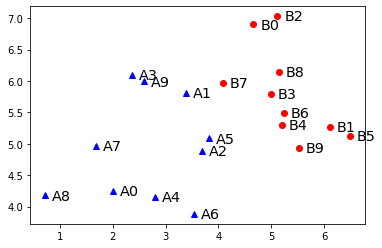

In [13]:
contrivedTest(10, False)